<h1> <center> Ejercicio en clase </center> </h1>
<p> El siguiente ejercicio en clase busca abordar un problema de clasificación con el uso de las distintas técnicas vistas en clase, para ello presentamos a continuación desde la exploración de la información, balanceo de los datos, hasta las distintas aproximaciones y comparaciones entre los modelos. </p>
<p> Cada sección posee una serie de ejercicios que usted tendrá que solucionar, por el momento no se preocupe, que lo realizaremos como equipo </p>

## Ejercicio
En este ejercicio buscamos detectar si una operación es un fraude o no, para ello utilizaremos distintas técnicas que nos permitan aproximarnos a la respuesta

## Base de datos
En este ejercicio seleccionaremos una base de datos denominada como ```credit```, la cual contienen las transacciones realizadas en dos días con tarjetas de crédito en septiembre de 2013 en Europa. En estos datos se identifican 492 fraudes de 284,807 transacciones. El conjunto de datos está altamente desequilibrado, pues la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Por temas de confidencialidad esta base de datos contiene información anonimizada con PCA,  (V1,...,V28), exceptuando las características  ```Tiempo``` y ```Cantidad```. La variable ```Tiempo``` contiene los segundos transcurridos entre cada transacción, mientras que la variable ```Cantidad``` es la Cantidad de la transacción, mientras que la variable ```Clase``` es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Esta base de datos la puede encontrar en el siguiente [link](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [19]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install warnings


  ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [20]:
# Classic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# Data manipulation
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler

# Models
import statsmodels.api as sm2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve 

## Exploración de la base de datos
Comencemos con una exploración básica de la información de créditos


In [21]:
dataset = pd.read_csv('credit.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.759072e-12,-8.251146e-13,-9.655448e-13,8.321385e-13,1.649983e-13,4.248434e-13,-3.054696e-13,8.777981e-14,-1.179757e-12,...,-3.405785e-13,-5.723165e-13,-9.725860e-13,1.464148e-12,-6.987110e-13,-5.617884e-13,3.332082e-12,-3.518875e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [23]:
dataset.isnull().sum().sum()

0

In [24]:
dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Ejercicio
Realice una tabla en la que calcule el porcentaje de clases 0 y 1 que tenemos en la base de datos

In [25]:
# Escriba aquí su código

Text(0.5, 1.0, 'Distribución de Fraude')

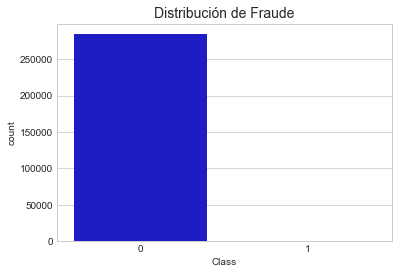

In [26]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=dataset, palette=colors)
plt.title('Distribución de Fraude', fontsize=14)

Es claro que nuestra base se encuentra desbalanceada, es decir, tenemos muy poca información para identificar patrones de fraude en las transacciones

### Escalar / Estandarizar

In [27]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

dataset['scaled_amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['scaled_time'] = rob_scaler.fit_transform(dataset['Time'].values.reshape(-1,1))

dataset.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = dataset['scaled_amount']
scaled_time = dataset['scaled_time']

dataset.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
dataset.insert(0, 'scaled_amount', scaled_amount)

dataset.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Balanceo de la base de datos
Para este caso, existen múltiples soluciones, entre ellas:
1. No tener en cuenta las métricas de precisión y puntajes F1 a la hora de validar los modelos
2. Trabajar con algoritmos adecuados - Random Forest
3. Trabajar con técnicas de remuestreo que aumente o disminuyan la información
4. Generación de muestras sintéticas

En este ejercicio se mostraran las distintas técnicas, pero solo se trabajara con una de ellas, como ejercicio usted deberá seleccionar la muestra que mejor se adecue a lo que está buscando



#### Reducción de la muestra de la clase dominante con remuestreo



In [28]:
df = dataset.sample(frac=1)

df_fraude = df.loc[df['Class'] == 1]
df_n_fraude = df.loc[df['Class'] == 0][:492]

df_tamaño = pd.concat([df_fraude, df_n_fraude])
df = df_tamaño.sample(frac=1, random_state=42)

df.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [29]:
df_fraude = dataset.loc[dataset['Class'] == 1]
df_n_fraude = dataset.loc[dataset['Class'] == 0]

df_n_fraude = resample(df_n_fraude,
                       replace = False,
                       n_samples = len(df_fraude),
                       random_state = 27)

df2 = pd.concat([df_n_fraude, df_fraude])

df2.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

#### Aumento de la muestra de la clase no dominante con remuestreo

In [30]:
y = dataset.Class
X = dataset.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
X = pd.concat([X_train, y_train], axis=1)
df_n_fraude = X[X.Class==0]
df_fraude = X[X.Class==1]

df3 = resample(df_fraude,
               replace=True,
               n_samples=len(df_n_fraude),
               random_state=27)

df3 = pd.concat([df_n_fraude, df3])

df3.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

#### Balanceo con muestra sintentica
Esta técnica busca un submuestre de la información con los vecinos más cercanos

In [31]:
y = dataset.Class
X = dataset.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
np.array(np.unique(y_train, return_counts=True)).T

array([[     0, 213245],
       [     1, 213245]])

## Entrenamiento con distintos modelos

Al tener balanceada nuestra información balanceada, procederemos a evaluar los distintos modelos y seleccionar aquel que mejor resultado nos arroje

### Modelo de regresión logística

In [32]:
logit = LogisticRegression(solver='lbfgs')
logit_model = logit.fit(X_train,y_train)
logit_pred = logit_model.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, logit_pred)
print(1)

1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Naïve Bayes

In [16]:
def hyperopt_train_test(params):
    clf = BernoulliNB(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4knn = {
    'alpha': hp.uniform('alpha', 0.0, 2.0)
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|██████████| 10/10 [00:08<00:00,  1.23it/s, best loss: -0.9125067415744194]
best:
{'alpha': 0.13054847911498313}


In [17]:
NaiveBayes = BernoulliNB(alpha=0.09827861224760026)
NB_model = NaiveBayes.fit(X_train,y_train)
NB_pred = NB_model.predict(X_test)
NB_roc_auc = roc_auc_score(y_test, NB_pred)

### K Nearest Neighbor

In [ ]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(2,10))
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

In [ ]:
2

In [18]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN_model = KNN.fit(X_train,y_train)
KNN_pred = KNN_model.predict(X_test)
KNN_roc_auc = roc_auc_score(y_test, KNN_pred)
print(1)

KeyboardInterrupt: 

### Decision Tree

In [33]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def hyperopt_train_test(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|██████████| 10/10 [00:39<00:00,  4.00s/it, best loss: -0.9953246273177037]
best:
{'criterion': 0, 'max_depth': 16, 'max_features': 3}


In [35]:
DT = DecisionTreeClassifier(criterion = "gini", max_depth = 16, max_features = 3)
DT.fit(X_train,y_train)
DT_pred = DT.predict(X_test)
DT_roc_auc = roc_auc_score(y_test, DT_pred)

### Random Forest

In [37]:
def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|██████████| 10/10 [04:13<00:00, 25.38s/it, best loss: -0.9996576705123811]
best:
{'criterion': 0, 'max_depth': 16, 'max_features': 2, 'n_estimators': 12}


In [39]:
RF = RandomForestClassifier(criterion="gini", max_depth=16, max_features=2, 
                            n_estimators=12)
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)
RF_roc_auc = roc_auc_score(y_test, RF_pred)
print(1)

1


### Gradient Boosting

In [47]:
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=3, trials=trials)
print('best:')
print(best)

100%|██████████| 3/3 [07:32<00:00, 150.78s/it, best loss: -0.999758493630358]
best:
{'learning_rate': 0.18726176049598348, 'max_depth': 17, 'max_features': 1, 'n_estimators': 11}


In [ ]:
GB = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
GB.fit(X_train, y_train)
GB_pred = GB.predict(X_test)
GB_roc_auc = roc_auc_score(y_test, GB_pred)
print(1)

### Comparación entre los distintos modelos
En este caso seleccionamos el criterio de la curva de ROC para seleccionar cual es el mejor modelo.

El área bajo la curva (AUC) y la curva ROC son métricas de evaluación para verificar el rendimiento de un modelo de clasificación

La curva ROC nos dice que tan bueno puede distiguir un modelo entre 2 clases distintas
Mientras que AUC, mide la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.


#### AUC

In [ ]:
print('Regresión Logit: ',logit_roc_auc)
print('Naïve Bayes: ',NB_roc_auc)
print('K Near Neighbor: ',KNN_roc_auc)
print('Árbol de decisión: ',DT_roc_auc)
print('Random Forest: ',RF_roc_auc)
print('Gradient Boosting: ',GB_roc_auc)

In [ ]:
logit_fpr, logit_tpr, thresholds = roc_curve(y_test, logit.predict_log_proba(X_test)[:,1])
NB_fpr, NB_tpr, thresholds = roc_curve(y_test, NB_model.predict_proba(X_test)[:, 1])
KNN_fpr, KNN_tpr, thresholds = roc_curve(y_test, KNN_model.predict_proba(X_test)[:, 1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:, 1])
RF_fpr, RF_tpr, thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:, 1])
GB_fpr, GB_tpr, thresholds = roc_curve(y_test, GB.predict_proba(X_test)[:, 1])

#### Curva ROC

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(logit_fpr, logit_tpr, label='Regresión Logística')
plt.plot(NB_fpr, NB_tpr, label='NB')
plt.plot(KNN_fpr, KNN_tpr, label='KNN')
plt.plot(DT_fpr, DT_tpr, label='DT')
plt.plot(RF_fpr, RF_tpr, label='RF')
plt.plot(GB_fpr, GB_tpr, label='GB')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Característica de funcionamiento del receptor (Curva ROC)')
plt.legend(loc="lower right")

### Ejercicio

Con la base de emails, verifique que se encuentra balanceada, sino balancee la base con cualquier técnica y muestre cuál es la mejor técnica para predecir si un correo es spam o no

In [44]:
list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3))

[0.006350024818026649,
 0.006414734386247674,
 0.006480103373658278,
 0.006546138500032374,
 0.006612846553621324,
 0.0066802343918518055,
 0.006748308942030692,
 0.006817077202057208,
 0.006886546241142249,
 0.006956723200535129,
 0.007027615294257632,
 0.007099229809845653,
 0.007171574109098275,
 0.007244655628834609,
 0.007318481881658223,
 0.007393060456729473,
 0.007468399020545594,
 0.007544505317728856,
 0.007621387171822637,
 0.007699052486095717,
 0.0077775092443546695,
 0.007856765511764592,
 0.007936829435678219,
 0.008017709246473386,
 0.00809941325839916,
 0.008181949870430461,
 0.008265327567131522,
 0.008349554919528008,
 0.008434640585988173,
 0.00852059331311285,
 0.008607421936634645,
 0.00869513538232616,
 0.008783742666917614,
 0.008873252899023668,
 0.008963675280079844,
 0.009055019105288331,
 0.00914729376457359,
 0.009240508743547532,
 0.009334673624484703,
 0.009429798087307237,
 0.009525891910579998,
 0.009622964972515738,
 0.009721027251990574,
 0.0098200888